In [28]:
import pandas as pd
import numpy as np
from pymoo.algorithms.nsga3 import NSGA3
from pymoo.algorithms.rnsga2 import RNSGA2
from pymoo.algorithms.rnsga3 import RNSGA3
from pymoo.algorithms.unsga3 import UNSGA3
from pymoo.optimize import minimize
import pickle

from pymoo.util.termination.f_tol import MultiObjectiveSpaceToleranceTermination

from notebooks.optimization_problems.constraints import Requirements
%load_ext autoreload

%autoreload 2

prefix = "iot_"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
columns = ['strand_name', 'tof',
           'r_a_x', 'r_a_y', 'r_a_z',
           'v_a_x', 'v_a_y', 'v_a_z',
           'r_b_x', 'r_b_y', 'r_b_z',
           'd',
           'r_ab_sff_x', 'r_ab_sff_y', 'r_ab_sff_z']

file_path = "raw/eo_telesat_post_processed.h5"

row_limit = -1

store = pd.HDFStore(file_path)

instances_df = store.select('contact_instances', 'columns = %s' % str(columns), stop = row_limit)

# Sort by pass id
instances_df = instances_df.sort_index(0)

In [5]:
case, target = pickle.load(open('raw/%ssettings.pkl' % prefix, 'rb'))

import util
util.print_targets(case)

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!
Targets per orbit
T_target: 20.00 Gb (min: 20.00 Gb, max: 40.00 Gb)
L_target: 0.00 s
E_target: 16.82 kJ (max: -0.00 kJ)
P_target: 0.00 s


In [19]:
from notebooks.optimization_problems.design_vector import design_vector_default_scm, SystemParameters

sys_param = SystemParameters()
sys_param.fc_Hz = target['frequency']
sys_param.GT_dBK = target['GT_dBK']
sys_param.margin_dB = 3.0
sys_param.B_Hz_array = np.array([0.1, 0.5, 1, 10, 50, 100, 200, 300]) * 1e6
sys_param.B_Hz_array = np.array([0.1, 0.5, 1, 10, 50]) * 1e6
sys_param.Gtx_dBi_bounds = (3., 50.)
sys_param.Ptx_dBm_bounds = (20., 43.)

modcods_df = pd.read_pickle('../dvbs2.pkl')

sys_param.EsN0_req_dB_array = modcods_df[['isend', 'isend_200MHz', 'isend_300MHz']].to_numpy()
sys_param.eta_bitsym_array = modcods_df[['eta', 'eta_200MHz', 'eta_300MHz']].to_numpy()
sys_param.eta_maee_array = modcods_df[['maee_12', 'maee_12_200MHz', 'maee_12_300MHz']].to_numpy()

requirements = case['requirements']
#requirements.max_energy = -1

Initial conditions optimization

init_ref_dirs: 201
init_pop_size: 300
init_n_offsprings: 75
Loading initial conditions...
Plotting 10 results


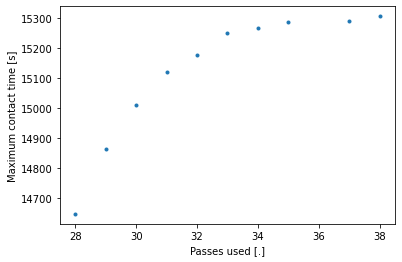

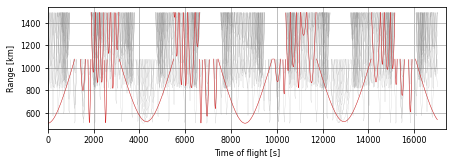

In [42]:
from contact_problem import ContactProblemDownSelect

problem = ContactProblemDownSelect(instances_df, sys_param)
sampling, crossover, mutation = design_vector_default_scm(problem.x_length, problem.x_indices)

# NGSA-III optimization
from pymoo.factory import get_reference_directions
init_ref_dirs = get_reference_directions("das-dennis", 2, n_partitions=200)
init_pop_size = int(np.ceil(len(init_ref_dirs) / 100) * 100)
init_n_offsprings = int(np.ceil(len(init_ref_dirs) / 100) * 100 / 4)
#init_ref_points = np.array([[-0.0, 0.0], [case['T_sim_s'], problem.N_passes]])

print("init_ref_dirs: %d" % len(init_ref_dirs))
print("init_pop_size: %d" % init_pop_size)
print("init_n_offsprings: %d" % init_n_offsprings)

init_file_name = 'raw/%stelesat_init_%d_%d.pkl' % (prefix, init_pop_size, init_n_offsprings)

from os import path
if not path.exists(init_file_name):
    algorithm = NSGA3(
            pop_size=init_pop_size,
            n_offsprings=init_n_offsprings,
            sampling=sampling,
            crossover=crossover,
            mutation=mutation,
            ref_dirs=init_ref_dirs,
            eliminate_duplicates=False,
        )

    termination = MultiObjectiveSpaceToleranceTermination(tol=0.00001,
                                                          n_last=30,
                                                          nth_gen=5,
                                                          n_max_gen=None,
                                                          n_max_evals=None)

    print("Running initial conditions optimization..")
    init_res = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   #verbose=True,
                   copy_algorithm=False,
                   )

    pickle.dump(init_res, open(init_file_name, 'wb'))
else:
    print("Loading initial conditions...")
    init_res = pickle.load(open(init_file_name, 'rb'))

print("Plotting %d results" % len(init_res.X))

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(init_res.F[:, 1], init_res.F[:, 0] * -1, marker='.')
ax.set_xlabel('Passes used [.]')
ax.set_ylabel('Maximum contact time [s]')

x_pass, x_Ptx_dBm, x_Gtx_dBi, x_B_Hz = util.get_selection(problem, init_res)

util.plot_used_passes(case, instances_df, problem, x_pass[np.argmin(init_res.F[:,0]), :])


Problem definition

In [43]:
from combined_problem import ExtendedCombinedProblem
problem = ExtendedCombinedProblem(instances_df, sys_param, requirements=requirements, f_mask=np.array([1, 2, 3]))

Algorithm settings

In [48]:
def generate_init_pop(init_res, problem, pop_size, sampling):
    print("Generating initial population of size %d..." % pop_size)
    init_pop = init_res.X # Load design variables
    init_pop[:, problem.x_indices['pass']] = x_pass # Filter downselected passes
    repeats = int(np.ceil(pop_size / len(init_res.X)))
    init_pop = np.tile(init_pop, (repeats, 1))
    init_pop = init_pop[0:pop_size, :] # Reduce to population size
    sample_pop = sampling._do(problem, pop_size) # Sample a random population
    sample_pop[:, problem.x_indices['pass']] = init_pop[:, problem.x_indices['pass']] # Set pass selection
    return sample_pop

settings = {}

# NSGA-III
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=23)
pop_size=int(np.ceil(len(ref_dirs) / 100) * 100)
n_offsprings=int(np.ceil(len(ref_dirs) / 100) * 100 / 4)

settings['NSGA-III'] = {
    'label': 'nsga3',
    'algorithm': NSGA3(
        pop_size=pop_size,
        n_offsprings=n_offsprings,
        sampling=generate_init_pop(init_res, problem, pop_size, sampling),
        crossover=crossover,
        mutation=mutation,
        ref_dirs=ref_dirs,
        eliminate_duplicates=True,
    ),
    'desc': 'NSGA 3 ref_dirs=%s, pop_size=%s, n_offsprings=%s' % (len(ref_dirs), pop_size, n_offsprings),
    'termination': ""
}

setting = settings['NSGA-III']

print("Selected setting: %s" % setting['desc'])

Generating initial population of size 300...
Selected setting: NSGA 3 ref_dirs=300, pop_size=300, n_offsprings=75


In [52]:

algo_settings = {'pop_size': 200, 'n_offsprings': 50, 'n_max_gen': 5000}

settings = {}

ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=15)
settings['UNSGA-III'] = {
    'label': 'unsga3',
    'algorithm': UNSGA3(
        pop_size=int(np.ceil(len(ref_dirs) / 100) * 100),
        n_offsprings=int(np.ceil(len(ref_dirs) / 100) * 100 / 4),
        sampling=sampling,
        crossover=crossover,
        mutation=mutation,
        ref_dirs=ref_dirs,
        eliminate_duplicates=True,
    ),
    'termination': ""
}

ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=23)
print(len(ref_dirs))
settings['NSGA-III'] = {
    'label': 'nsga3',
    'algorithm': NSGA3(
        pop_size=int(np.ceil(len(ref_dirs) / 100) * 100),
        n_offsprings=int(np.ceil(len(ref_dirs) / 100) * 100 / 4),
        sampling=sampling,
        crossover=crossover,
        mutation=mutation,
        ref_dirs=ref_dirs,
        eliminate_duplicates=True,
    ),
    'termination': ""
}

# Continue with R-NSGA-2
problem, setting, res = pickle.load(open("raw/iot_telesat_nsga3_300_75.pkl", 'rb'))
ref_points = np.array([[case['T_bitorbit_target'], case['L_sorbit_target'], case['E_Jorbit_target'], case['P_sorbit_target']]])
ref_points = ref_points * (case['T_sim_s'] / case['T_orbit_s'])
ref_points = ref_points *  np.array([-1, 1, 1, 1])
ref_points = ref_points[:, problem.f_mask]

settings['R-NSGA-II-CONT'] = {
    'label': 'rnsga2_1e-2_cont',
    'algorithm': RNSGA2(
        pop_size=int(np.ceil(len(res.algorithm.ref_dirs) / 100) * 100),
        n_offsprings=int(np.ceil(len(res.algorithm.ref_dirs) / 100) * 100 / 4),
        sampling=res.X,
        crossover=crossover,
        mutation=mutation,
        eliminate_duplicates=True,
        ref_points=ref_points,
        epsilon=0.01,
        normalization='front',
        extreme_points_as_reference_points=False,
        weights=np.array([0.75, 0.25, 0])
    ),
    'termination': ""
}

setting = settings['UNSGA-III']
setting = settings['NSGA-III']
setting = settings['R-NSGA-II-CONT']

300


In [53]:
termination = setting['termination']
algorithm = setting['algorithm']

n_gen_inc = 900

from os import path

file_name = 'raw/iot_telesat_%s_%d_%d.pkl' % (setting['label'], algorithm.pop_size, algorithm.n_offsprings)

if path.exists(file_name):
    problem, setting, res = pickle.load(open(file_name, 'rb'))
    algorithm = res.algorithm
    algorithm.has_terminated = False
    n_gen = res.algorithm.n_gen
else:
    n_gen = 0

In [54]:
n_gen = n_gen + n_gen_inc
print(n_gen)
termination = ('n_gen', n_gen)

1000


In [55]:
res = minimize(problem,
               algorithm,
               termination,
               #termination=termination,
               seed=1,
               #save_history=True,
               verbose=True,
               copy_algorithm=False,
               )

print('Processes:', res.exec_time)
print("Best solution found: %s" % res.X)

pickle.dump((problem, setting, res), open(file_name, 'wb'))

  101 |    7605 |  0.00000E+00 |  0.00000E+00 |     300 |  0.000075486 |            f
  102 |    7680 |  0.00000E+00 |  0.00000E+00 |     300 |  0.000040033 |            f
  103 |    7755 |  0.00000E+00 |  0.00000E+00 |     298 |  0.000249450 |            f
  104 |    7830 |  0.00000E+00 |  0.00000E+00 |     300 |  0.000253886 |            f
  105 |    7905 |  0.00000E+00 |  0.00000E+00 |     300 |  0.000126189 |            f
  106 |    7980 |  0.00000E+00 |  0.00000E+00 |     300 |  0.00000E+00 |            f
  107 |    8055 |  0.00000E+00 |  0.00000E+00 |     300 |  0.000075192 |            f
  108 |    8130 |  0.00000E+00 |  0.00000E+00 |     300 |  2.86148E-06 |            f
  109 |    8205 |  0.00000E+00 |  0.00000E+00 |     300 |  0.00000E+00 |            f
  110 |    8280 |  0.00000E+00 |  0.00000E+00 |     300 |  0.00000E+00 |            f
  111 |    8355 |  0.00000E+00 |  0.00000E+00 |     300 |  0.000222451 |            f
  112 |    8430 |  0.00000E+00 |  0.00000E+00 |     30

In [56]:
from beepy import beep
for i in range(3):
    beep(sound=5)
